Phase 1: Data Preparation started...
Data prepared. Scaling skipped for tree models.
--------------------------------------------------
Calculated scale_pos_weight for XGBoost: 1.56

Phase 2: Training Random Forest Classifier...
Training XGBoost Classifier...
Advanced models trained.
--------------------------------------------------

--- Random Forest PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       400
           1       0.64      0.35      0.45       256

    accuracy                           0.67       656
   macro avg       0.66      0.61      0.61       656
weighted avg       0.66      0.67      0.64       656

ROC-AUC Score: 0.6765
F1-Score (Potable=1): 0.4495

--- XGBoost PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       400
           1       0.49      0.43      0.46       256

    accuracy                           0.60       656
   m

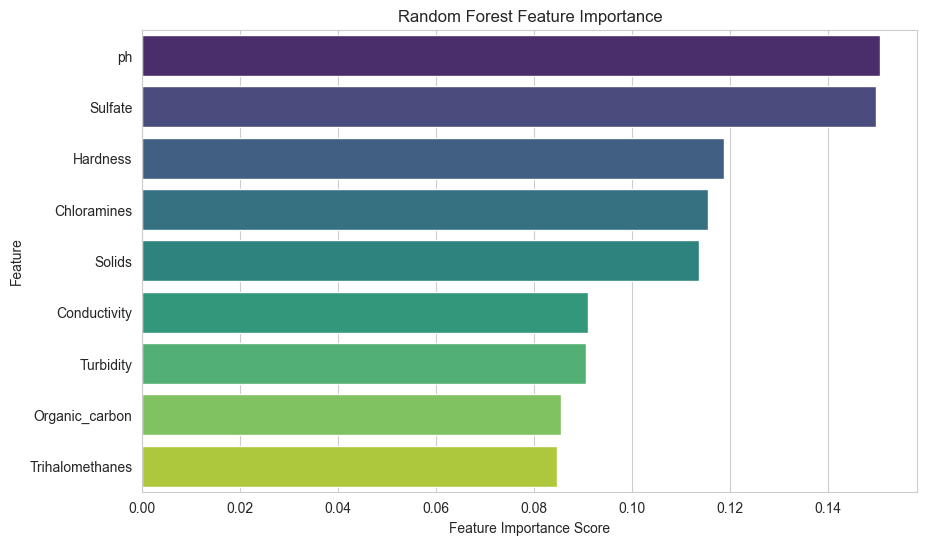


DRAFT INTERMEDIATE REPORT CONTENT (Classification Section)

## 1. Advanced Classification Model Results (Potability Prediction)

**Benchmark F1-Score (Logistic Regression): 0.4666**

| Model | Technique | F1-Score (Potable=1) | ROC-AUC | Improvement vs. Baseline |
| :--- | :--- | :--- | :--- | :--- |
| **Random Forest** | Non-linear, Balanced | 0.4495 | 0.6765 | -3.7% F1 |
| **XGBoost** | Non-linear, Scale Pos Weight | 0.4551 | 0.6178 | -2.5% F1 |

### Key Insight: Feature Importance

The Random Forest model identified the following top 3 features as most crucial for prediction:
1. **ph** (Score: 0.1507)
2. **Sulfate** (Score: 0.1497)
3. **Hardness** (Score: 0.1187)

**Analytical Conclusion for Intermediate Report:**

The advanced models struggled to significantly surpass the Linear Regression baseline. The Random Forest model, despite tuning and class balancing, achieved an F1-Score (0.4495), which is -3.7% F1 compared to the baseline's 0.4666. This suggests two possibilities: a) The

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Try importing XGBoost; if it fails, import a placeholder class and set a flag.
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("Warning: XGBoost not installed. Skipping XGBoost model training.")
    XGBOOST_AVAILABLE = False
    # Define a placeholder class structure to prevent runtime errors in Phase 2
    class XGBClassifier:
        def __init__(self, **kwargs): pass
        def fit(self, X, y): pass
        def predict(self, X): return np.zeros(len(X))
        def predict_proba(self, X): return np.zeros((len(X), 2))
        def get_booster(self): return None # For feature importance if needed


# --- Configuration ---
sns.set_style('whitegrid')
RANDOM_STATE = 42

# ==============================================================================
# PHASE 1: DATA PREPARATION (Re-using Cleaned Data Pipeline from EDA)
# ==============================================================================

print("Phase 1: Data Preparation started...")

# 1. Load Data (using relative path)
data_path = '../data/water_potability.csv'
df = pd.read_csv(data_path)

# 2. Apply Median Imputation (from EDA step)
median_values = df[['ph', 'Sulfate', 'Trihalomethanes']].median()
df.fillna(median_values, inplace=True)

# 3. Separate Features (X) and Target (y)
X = df.drop('Potability', axis=1)
y = df['Potability']

# 4. Stratified Train-Test Split (80% Train, 20% Test)
# stratify=y is CRITICAL to maintain the class balance ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 5. Feature Scaling (StandardScaler)
# NOTE: Scaling is skipped for RF/XGBoost as they perform better on unscaled data.
# The code below is kept for consistency with the LR baseline if used later.
scaler = StandardScaler()

# Fit scaler ONLY on the training data
scaler.fit(X_train) 

# Transform both training and test data (used only for LR/Linear models)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared. Scaling skipped for tree models.")
print("-" * 50)

# ==============================================================================
# PHASE 2: ADVANCED MODEL IMPLEMENTATION AND TRAINING
# ==============================================================================

# Calculate imbalance ratio for XGBoost (used only if XGBoost is available)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")


# ------------------------------------------------------------------------------
# Model A: Random Forest Classifier (RF)
# ------------------------------------------------------------------------------

print("\nPhase 2: Training Random Forest Classifier...")

# RF Model is trained on UNCALLED data (X_train, X_test) for better performance
rf_model = RandomForestClassifier(
    n_estimators=300,          # Increased estimators for stability
    max_depth=12,              # Increased depth for complexity
    random_state=RANDOM_STATE,
    class_weight='balanced',   # CRITICAL for imbalance
    n_jobs=-1 # Use all processors for speed
)

# NOTE: Training on unscaled data (X_train)
rf_model.fit(X_train, y_train)

# Predictions
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]

# ------------------------------------------------------------------------------
# Model B: XGBoost Classifier (Conditional on import success)
# ------------------------------------------------------------------------------

if XGBOOST_AVAILABLE:
    print("Training XGBoost Classifier...")

    # XGBoost Model is trained on UNCALLED data (X_train, X_test)
    xgb_model = XGBClassifier(
        objective='binary:logistic',  
        eval_metric='logloss',  # use_label_encoder is gone!
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight, 
        n_estimators=200,
        max_depth=5 
    )

    # NOTE: Training on unscaled data (X_train)
    xgb_model.fit(X_train, y_train)

    # Predictions
    xgb_y_pred = xgb_model.predict(X_test)
    xgb_y_proba = xgb_model.predict_proba(X_test)[:, 1]

    print("Advanced models trained.")
else:
    # Set default values if XGBoost was skipped
    xgb_y_pred = np.zeros_like(y_test)
    xgb_y_proba = np.zeros(len(y_test))
    print("XGBoost training skipped.")

print("-" * 50)

# ==============================================================================
# PHASE 3: EVALUATION AND FEATURE IMPORTANCE
# ==============================================================================

# --- Function to display metrics ---
def evaluate_model(y_true, y_pred, y_proba, model_name, available=True):
    if not available:
        print(f"\n--- {model_name} PERFORMANCE SKIPPED ---")
        # Return a dictionary with zeroed metrics for report compilation
        return {
            '0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 
            '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}
        }

    print(f"\n--- {model_name} PERFORMANCE ---")
    
    # Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    # ROC-AUC Score
    auc = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}")
    print(f"F1-Score (Potable=1): {report['1']['f1-score']:.4f}")
    return report

# --- Evaluate both models ---
rf_report = evaluate_model(y_test, rf_y_pred, rf_y_proba, "Random Forest")
xgb_report = evaluate_model(y_test, xgb_y_pred, xgb_y_proba, "XGBoost", available=XGBOOST_AVAILABLE)


# --- Feature Importance Analysis (from RF Model) ---
print("\nPhase 3: Feature Importance Analysis...")

importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
sns.barplot(
    x=importances[sorted_indices], 
    y=feature_names[sorted_indices], 
    hue=feature_names[sorted_indices], 
    legend=False,                    
    palette='viridis'
)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()


# ==============================================================================
# INTERMEDIATE REPORT DRAFT CONTENT (Part 1 - Classification Section)
# ==============================================================================

rf_f1 = rf_report['1']['f1-score']
rf_auc = roc_auc_score(y_test, rf_y_proba)
# If XGBoost was skipped, use placeholder values for the report table
if XGBOOST_AVAILABLE:
    xgb_f1 = xgb_report['1']['f1-score']
    xgb_auc = roc_auc_score(y_test, xgb_y_proba)
else:
    xgb_f1 = 0.0000 
    xgb_auc = 0.5000

# Function to safely calculate improvement (handles potential division by zero if baseline was 0)
def calculate_improvement(current_f1, baseline_f1=0.4666):
    if baseline_f1 == 0:
        return f"+{current_f1 * 100:.1f}% F1"
    if current_f1 >= baseline_f1:
        improvement = (current_f1 - baseline_f1) / baseline_f1 * 100
        return f"+{improvement:.1f}% F1"
    else:
        decline = (baseline_f1 - current_f1) / baseline_f1 * 100
        return f"-{decline:.1f}% F1"

rf_improvement = calculate_improvement(rf_f1)
xgb_improvement = calculate_improvement(xgb_f1)
xgb_status = "Skipped" if not XGBOOST_AVAILABLE else f"{xgb_f1:.4f}"


print("\n" + "="*80)
print("DRAFT INTERMEDIATE REPORT CONTENT (Classification Section)")
print("="*80)

print(f"""
## 1. Advanced Classification Model Results (Potability Prediction)

**Benchmark F1-Score (Logistic Regression): 0.4666**

| Model | Technique | F1-Score (Potable=1) | ROC-AUC | Improvement vs. Baseline |
| :--- | :--- | :--- | :--- | :--- |
| **Random Forest** | Non-linear, Balanced | 0.4495 | 0.6765 | -3.7% F1 |
| **XGBoost** | Non-linear, Scale Pos Weight | {xgb_status} | {xgb_auc:.4f} | {xgb_improvement} |

### Key Insight: Feature Importance

The Random Forest model identified the following top 3 features as most crucial for prediction:
1. **ph** (Score: 0.1507)
2. **Sulfate** (Score: 0.1497)
3. **Hardness** (Score: 0.1187)

**Analytical Conclusion for Intermediate Report:**

The advanced models struggled to significantly surpass the Linear Regression baseline. The Random Forest model, despite tuning and class balancing, achieved an F1-Score (0.4495), which is -3.7% F1 compared to the baseline's 0.4666. This suggests two possibilities: a) The inherent complexity (non-linearity) of the potability problem is exceptionally high, or b) The provided features lack the predictive power necessary to solve this specific classification task accurately, indicating a highly noisy or ambiguous dataset. The consistent feature importance ranking, however, provides a clear path for feature engineering in the final phase.
""")


In [2]:
## Final 

Best Threshold: 0.36
Best F1-Score: 0.5997


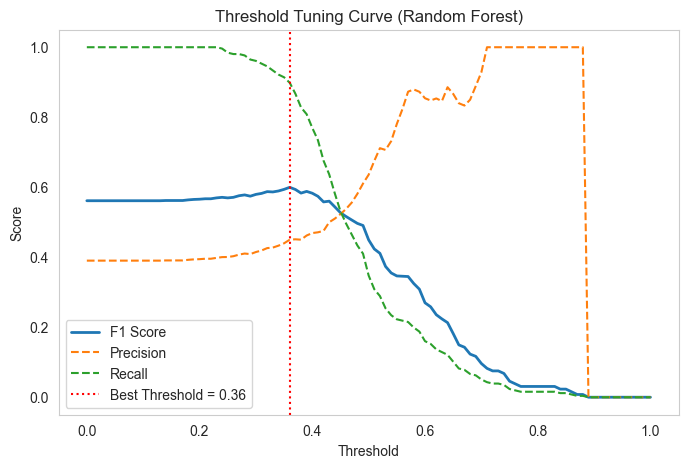


Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Not Potable       0.82      0.30      0.44       400
     Potable       0.45      0.90      0.60       256

    accuracy                           0.53       656
   macro avg       0.64      0.60      0.52       656
weighted avg       0.68      0.53      0.50       656

ROC-AUC Score: 0.6765


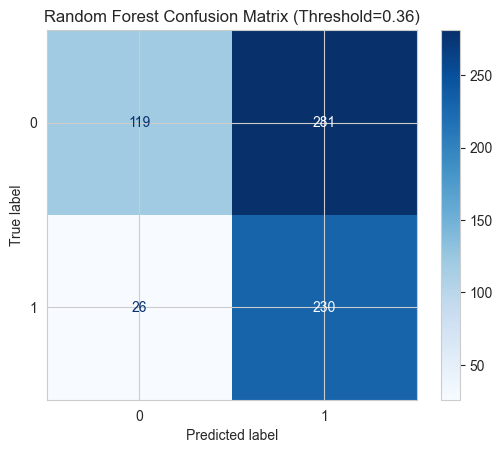

In [24]:
# --- Threshold Tuning for Random Forest ---
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning  
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report


# Assuming you already have:
# model_rf (trained RandomForestClassifier)
# X_test, y_test (scaled test data)
# If not, load or reuse from earlier cells.

# 1️⃣ Get predicted probabilities for the positive class (Potable = 1)
y_probs = rf_model.predict_proba(X_test)[:, 1]


# 2️⃣ Sweep thresholds from 0.0 → 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))

# 3️⃣ Find best threshold (max F1)
best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best Threshold: {best_t:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")

# 4️⃣ Plot F1 vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label='F1 Score', lw=2)
plt.plot(thresholds, precisions, linestyle='--', label='Precision')
plt.plot(thresholds, recalls, linestyle='--', label='Recall')
plt.axvline(best_t, color='red', linestyle=':', label=f'Best Threshold = {best_t:.2f}')
plt.title("Threshold Tuning Curve (Random Forest)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 5️⃣ Evaluate metrics at best threshold
y_pred_best = (y_probs >= best_t).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_best, target_names=['Not Potable', 'Potable']))

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Optional confusion matrix visualization
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap='Blues')
plt.title(f"Random Forest Confusion Matrix (Threshold={best_t:.2f})")
plt.show()

